# Corpus
This notebook is entirely for `Corpus` and `SpacyCorpus` class.

It will demonstrate how they are built and explore their functionalities and the more subtle accessors.

Related classes:
`Corpus`, `SpacyCorpus`, `CorpusBuilder`, `CorpusSlicer`, `SpacyProcessor`.

In [1]:
import os
if  not 'juxtorpus' in os.listdir():
    os.chdir('../../')
assert 'juxtorpus' in os.listdir(), f"Working directory should be at juxtorpus. But at {os.getcwd()}"
f"Working directory: {os.getcwd()}"

'Working directory: /Users/hcha9747/workspace/juxtorpus'

#### 1. Building a Corpus with CorpusBuilder

Current limitations:
- only accepts csv formats. (Please first write your own scripts to preprocess your data if required.)
- multiple files requires them to share the same columns.

Future:
- more loading pipelines - accepting of formats aside from csv.

In [2]:
from pathlib import Path

paths = [Path("./tests/assets/Geolocated_places_climate_with_LGA_and_remoteness_0.csv"),
         Path("./tests/assets/Geolocated_places_climate_with_LGA_and_remoteness_1.csv")]
for p in paths: assert p.exists()

In [3]:
from juxtorpus.corpus import Corpus, CorpusBuilder

builder = CorpusBuilder(paths)
builder.show_columns().T

All Columns,day,geometry,year,tweet_lga,tweet_id,state_name_2016,state_code_2016,screen_name,retweet,remoteness,remote_level,processed_text,month,lon_mid,lga_name_2020,lga_code_2020,lat_mid,year_month_day
Add,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [4]:
builder.head()     # loads to memory only the first n rows.

,year,month,day,lat_mid,lon_mid,screen_name,tweet_id,retweet,processed_text,geometry,tweet_lga,lga_code_2020,lga_name_2020,state_code_2016,state_name_2016,remoteness,remote_level,year_month_day
0,2019,11,29,-34.921620,138.598244,G_Westgarth,1.200000e+18,False,"<TWEET> ""Merry Crisis"", ""You cannot eat money""...","c(138.598244, -34.92162)",Adelaide (C),40070.0,Adelaide (C),4.0,South Australia,Major Cities of Australia,1.0,2019.11.29
1,2019,12,30,-34.928770,138.599702,adelparklands,1.210000e+18,False,<TWEET> #adelaideparklands #picoftheday \nThe ...,"c(138.599702, -34.92877)",Adelaide (C),40070.0,Adelaide (C),4.0,South Australia,Major Cities of Australia,1.0,2019.12.30
2,2020,1,29,-34.925639,138.600768,timklapdor,1.220000e+18,False,<TWEET> Same academics who would have their su...,"c(138.6007685, -34.925639)",Adelaide (C),40070.0,Adelaide (C),4.0,South Australia,Major Cities of Australia,1.0,2020.1.29


In [5]:
builder.add_metas(['tweet_lga', 'screen_name'], dtypes='category')
builder.add_metas('year_month_day', dtypes='datetime')  # this will keep meta id as 'year_month_day'
builder.add_metas('remote_level')       # dtype is inferred by pandas.
# note dtypes are pandas dtype, refer to their documentation.

In [6]:
import re
pattern = re.compile(r'<[/]?TWEET>')
builder.set_text_preprocessors([lambda t: pattern.sub('', t).strip()])
builder.set_text_column('processed_text')

corpus = builder.build()        # now corpus is in memory

In [7]:
print("Summary of corpus - incld. basic token level statistics")
corpus.summary().to_frame().T

[INFO] Building document-term matrix. Please wait...


Summary of corpus - incld. basic token level statistics


[INFO] Done.


,Corpus Type,Number of documents,Number of terms,Vocabulary size,Terms mean,Terms std,Terms min,Terms 25%,Terms 50%,Terms 75%,Terms max,metas
0,Corpus,20000,486127,35943,24.30635,16.313522,0.0,11.0,22.0,37.0,111.0,"tweet_lga, screen_name, year_month_day, remote..."


In [8]:
print("Summary of the meta data in the corpus.")
corpus.meta.summary()

Summary of the meta data in the corpus.


,dtype,sample,mean,std,min,25%,50%,75%,max,top,top_freq,uniqs,num_uniqs
tweet_lga,object,Adelaide (C),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
screen_name,object,G_Westgarth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year_month_day,datetime64[ns],2019-11-29 00:00:00,2020-07-16 05:05:25.439999744,255 days 23:34:42.676885548,2019-11-11 00:00:00,2020-01-02 00:00:00,2020-02-22 00:00:00,2021-01-03 00:00:00,2022-04-12 00:00:00,NaN,NaN,NaN,NaN
remote_level,float64,1.0,1.471865,0.734378,1.0,1.0,1.0,2.0,5.0,1.0,12691.0,"[1.0, 3.0, 2.0, 5.0, 4.0, nan]",6.0


In [9]:
# Accessing series of the metadata series directly.
corpus.meta.get('year_month_day').series().describe(datetime_is_numeric=True).to_frame().T

,count,mean,min,25%,50%,75%,max
year_month_day,20000,2020-07-16 05:05:25.439999744,2019-11-11,2020-01-02,2020-02-22,2021-01-03,2022-04-12


#### 2. Slicing the Corpus

The preferred way to slice the corpus is to access the `.slicer` property in Corpus. This will allow you to chain multiple slicing operations together.

Otherwise, you may wish to import `CorpusSlicer` and slice it that way. `.slicer` really just uses `CorpusSlicer` underneath the hood.

In [10]:
twentytwenty: Corpus = corpus.slicer.filter_by_datetime('year_month_day', start='01-01-2020', end='01-01-2021', strftime="%d-%m-%y")

# from juxtorpus.corpus import CorpusSlicer
# twentytwenty = CorpusSlicer(corpus).filter_by_datetime('year_month_day', start='01-01-2020', end='01-01-2021', strftime="%d-%m-%y")

[INFO] Converted start datetime : 2020y 01m 01d 00:00:00
[INFO] Converted end datetime   : 2021y 01m 01d 00:00:00


In [11]:
# Let's look at the summary() again for this sliced corpus.
twentytwenty.summary().to_frame().T

,Corpus Type,Number of documents,Number of terms,Vocabulary size,Terms mean,Terms std,Terms min,Terms 25%,Terms 50%,Terms 75%,Terms max,metas
0,Corpus,10134,240010,23013,23.683639,15.843954,0.0,11.0,21.0,37.0,107.0,"tweet_lga, screen_name, year_month_day, remote..."


In [12]:
# Let's group by the tweet_lgas

groups = list(twentytwenty.slicer.group_by('tweet_lga'))
for gid, group in groups[:5]:
    print(f"{gid.ljust(30)}\t{str(len(group)).ljust(4)} documents")

alexandrina = groups[4][1]
alexandrina.summary()

Adelaide (C)                  	8    documents
Adelaide Hills (DC)           	8    documents
Albany (C)                    	16   documents
Albury (C)                    	48   documents
Alexandrina (DC)              	252  documents


Corpus Type                                                       Corpus
Number of documents                                                  252
Number of terms                                                     4630
Vocabulary size                                                     1045
Terms mean                                                     18.373016
Terms std                                                      15.232976
Terms min                                                            0.0
Terms 25%                                                            5.0
Terms 50%                                                           12.0
Terms 75%                                                           31.0
Terms max                                                           55.0
metas                  tweet_lga, screen_name, year_month_day, remote...
dtype: object

In [13]:
# Let's see
screen_names = alexandrina.meta.get('screen_name').series().unique()
screen_names[:3]

array(['HeatherHalstead', 'SophiaMcGrane', 'SullJack48'], dtype=object)

In [14]:
# Let's filter for 'remote_level'
num = len(alexandrina.slicer.filter_by_item('screen_name', screen_names[0]))
f"Number of documents with a screen name that is HeatherHalstead' = {num}"

"Number of documents with a screen name that is HeatherHalstead' = 4"

In [15]:
# the most flexible slicing is via filter_by_condition
import re
num = len(alexandrina.slicer.filter_by_condition('screen_name', lambda name: re.match(r'^[HS].+', name) is not None))

f"Number of documents with a screen name that starts with 'H' or 'S' = {num}"

"Number of documents with a screen name that starts with 'H' or 'S' = 240"

#### 3. Document-Term Matrix DTM

Every Corpus allows you to access its `.dtm`. The `DTM` object that it returns houses a sparse matrix and exposes numerous functions for you to do further downstream analysis. The matrix is built using sklearn's `CountVectorizer`.


In [16]:
alexandrina.dtm, alexandrina.dtm.shape, alexandrina.dtm.matrix

(<DTM 252 docs X 35943 terms>,
 (252, 35943),
 <252x35943 sparse matrix of type '<class 'numpy.int64'>'
 	with 4208 stored elements in Compressed Sparse Row format>)

In [17]:
alexandrina.dtm.term_names[125:130]

array(['10mins', '10mm_404', '10newsfirst', '10newsfirstmelb',
       '10newsfirstqld'], dtype=object)

In [18]:
# Return a FreqTable of the dtm
alexandrina.dtm.total, alexandrina.dtm.freq_table().total

(4630, 4630)

In [19]:
# Return a new DTM with TFIDF values
tfidf = alexandrina.dtm.tfidf(use_idf=True, smooth_idf=True)   # pass in sklearn args

assert id(alexandrina.dtm) != id(tfidf), "TFIDF DTM is a new copy."
alexandrina.dtm.shape, tfidf.shape

((252, 35943), (252, 35943))

# SpacyCorpus

In NLP, we'll want to go a step further and perform tasks such as POS tagging, lemmatisation, entity extraction etc.

We have decided to use spacy as our dependency for these tasks due to its extendability and is feature rich out of the box.

Please note spacy's `Doc` objects are relatively expensive on the memory due to all the information that it stores. You can alleviate this by excluding components from spacy pipeline.

#### 3. Building a SpacyCorpus

The preferred way to process a Corpus into SpacyCorpus is by using the `process()` function.
This is a factory method that chooses whichever processor is appropriate given the keyword arguments kwargs. (Although we currently only support spacy)

NOTE: Please `detached()` a subcorpus first before processing with spacy due to index misalignment issues. This will be fixed in a later release.

In [20]:
alexandrina = alexandrina.detached()

# NOTE: this is a workaround - issues:
# DTM is rebuilt after processing, therefore the indexing is misaligned.
# detached() will make corpus a root corpus and process starts as new.

In [21]:
import spacy
from juxtorpus.corpus.processors import process

nlp = spacy.load('en_core_web_sm', exclude=['ner'])
scorpus = process(alexandrina, nlp=nlp)

[INFO] Processing corpus of 252 documents...
[INFO] Done.


In [22]:
summary, spacy_info = scorpus.summary(spacy=True)
spacy_info

[INFO] Building document-term matrix. Please wait...
[INFO] Done.


,0
lang,en
model,core_web_sm
pipeline,"tok2vec, tagger, parser, attribute_ruler, lemm..."


You will notice some subtle differences in the statistics of the original Corpus v.s. SpacyCorpus.
This is due to the difference in tokenisations methods used. SpacyCorpus uses spacy's tokenisation method. This is to be expected.

In [23]:
import pandas as pd
pd.concat([alexandrina.summary(), summary], axis=1)

[INFO] Building document-term matrix. Please wait...
[INFO] Done.


,0,1
Corpus Type,Corpus,SpacyCorpus
Number of documents,252,252
Number of terms,4630,4352
Vocabulary size,1045,957
Terms mean,18.373016,17.269841
Terms std,15.232976,14.599248
Terms min,0.0,0.0
Terms 25%,5.0,5.0
Terms 50%,12.0,11.0
Terms 75%,31.0,29.0


#### 4. Slicing a SpacyCorpus

Slicing a spacy corpus is just like slicing a Corpus. However, you may also choose to use [spacy's Matchers](https://spacy.io/usage/rule-based-matching).


In [24]:
# demo: previous filter_by_item
sliced = scorpus.slicer.filter_by_item('screen_name', screen_names[0])
screen_names[0], sliced.meta.get('screen_name').series().unique()

('HeatherHalstead', array(['HeatherHalstead'], dtype=object))

In [25]:
# demo: new filter_by_matcher
from juxtorpus.matchers import hashtags
matcher = hashtags(scorpus.nlp.vocab)            # predefined matcher
ht = scorpus.slicer.filter_by_matcher(matcher)

In [26]:
ht.summary()

Corpus Type                                                  SpacyCorpus
Number of documents                                                   10
Number of terms                                                      267
Vocabulary size                                                      169
Terms mean                                                          26.7
Terms std                                                      13.106826
Terms min                                                            1.0
Terms 25%                                                          24.75
Terms 50%                                                           28.0
Terms 75%                                                           31.0
Terms max                                                           44.0
metas                  tweet_lga, screen_name, year_month_day, remote...
dtype: object

In [27]:
print("These are all the documents containing at least one hashtag.")
print("="*100)
for doc in ht:
    print("-"*100)
    print(doc)

These are all the documents containing at least one hashtag.
----------------------------------------------------------------------------------------------------
as soon as the questions from the media pack turned to action on the climate emergency, Morrison abruptly ends questions and walks off #fuckwit
----------------------------------------------------------------------------------------------------
Calling out all Liberal Staffers- if you think the PMs latest presser is a success please realise it's a fail. Arsonists National Parks Jenny Not addressing Climate Change Smirking- Big Fail #ScoMoResign #ScottMorrison #AustraliaBushfires
----------------------------------------------------------------------------------------------------
there is no point in relying just on 'adaptation' ffs..
there is a limit to how much 'adaptation' there can be to the rapidly escalating human caused climate change emergency we are experiencing right now! adaptation on its own WILL NOT SAVE US  #qanda


In [28]:
scorpus.meta.summary().uniqs.screen_name

array(['HeatherHalstead', 'SophiaMcGrane', 'SullJack48', 'cidec35',
       'Tigersroar44', 'alexczarn', 'clintondkaus', 'NatalieParletta',
       'sbmcdonnell'], dtype=object)

In [29]:
groups = list(scorpus.slicer.group_by('screen_name'))
for gid, group in groups[:5]:
    print(f"{gid.ljust(30)}\t{str(len(group)).ljust(4)} documents")

HeatherHalstead               	4    documents
NatalieParletta               	2    documents
SophiaMcGrane                 	38   documents
SullJack48                    	198  documents
Tigersroar44                  	3    documents


# Bit of Jux

In [30]:
from juxtorpus import Jux

jux = Jux(scorpus.slicer.filter_by_item('screen_name', 'SullJack48'), scorpus.slicer.filter_by_item('screen_name', 'SophiaMcGrane'))

In [31]:
jux.summary()

,corpus_0,corpus_1
Corpus Type,SpacyCorpus,SpacyCorpus
Number of documents,198,38
Number of terms,3092,782
Vocabulary size,543,397
Terms mean,15.616162,20.578947
Terms std,13.864615,15.163312
Terms min,1.0,1.0
Terms 25%,4.25,8.5
Terms 50%,10.0,14.5
Terms 75%,27.0,33.5


In [32]:
jux.lexical_diversity()

{'corpus_0': 67.56610962379995, 'corpus_1': 59.59301357680207}

In [33]:
jux.sim.jaccard()

0.14774114774114774

In [34]:
jux.sim.cosine_similarity('tf')

0.5560542070632444

In [35]:
jux.sim.cosine_similarity('tfidf')

0.49034617171604333

In [36]:
jux.sim.cosine_similarity('log_likelihood')

0.5546529783869523

In [37]:
jux.stats.log_likelihood_and_effect_size()

,log_likelihood_llv,bayes_factor_bic,effect_size_ell
a,14.938348,6.676305,0.002002
able,0.450939,-7.811104,-0.000073
about,0.000107,-8.261935,0.000003
above,0.450939,-7.811104,-0.000073
according,1.352817,-6.909226,-0.000696
...,...,...,...
yeah,6.400752,-1.861290,-0.001822
yep,3.200376,-5.061667,-0.000516
young,3.200376,-5.061667,-0.000516
yourself,3.200376,-5.061667,-0.000516


In [44]:
from nltk.corpus import stopwords

sw = stopwords.words('english')

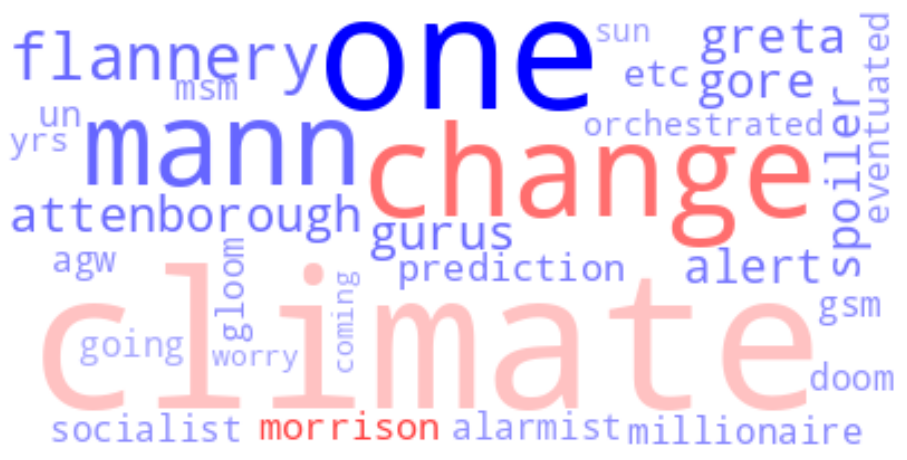

In [47]:
from juxtorpus.viz.polarity_wordcloud import PolarityWordCloud
df = jux.polarity.log_likelihood()
# tfidf_df = jux.polarity.tfidf()
# df['size'] = tfidf_df.polarity.abs()
tf_df = jux.polarity.tf()
df['size'] = tf_df.freq_corpus_0 + tf_df.freq_corpus_1
df = df[~df.index.isin(sw)]
df_tmp = df.sort_values(by='size', ascending=False).iloc[:30]
pwc = PolarityWordCloud(df_tmp, col_polarity='polarity', col_size='size')
pwc.gradate('blue', 'red').render(16, 16)    # blue is SullJack, Red is SophiaMcGrane